In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import statsmodels.api as sm

random_seed = 2024

In [2]:
node_df = pd.read_csv('data/large_twitch_features.csv')


Distribution of dead_account:
0    162955
1      5159
Name: dead_account, dtype: int64


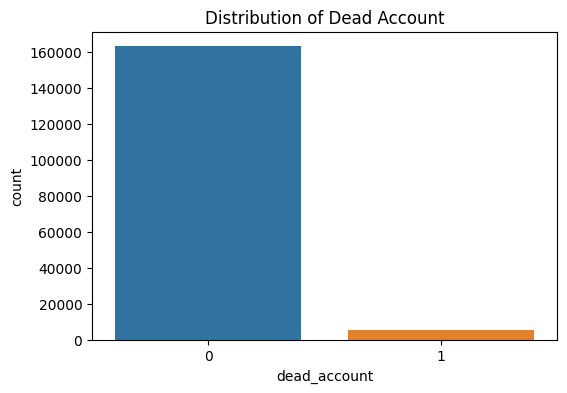

In [3]:
# Descriptive analysis

# Summary of dead_account
print("\nDistribution of dead_account:")
print(node_df['dead_account'].value_counts())

# Visualization of dead_account distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='dead_account', data=node_df)
plt.title('Distribution of Dead Account')
plt.show()

# Baseline Model

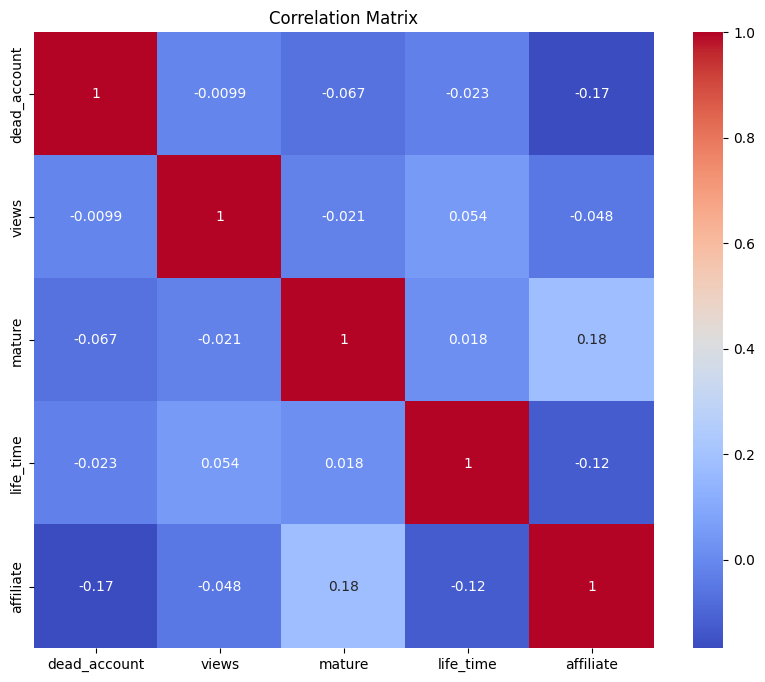

In [4]:
# encoding
node_df_encoded = pd.get_dummies(node_df, columns=['language'])

iv_list = ['views', 'mature', 'life_time', 'affiliate']
lang_list = [col for col in node_df_encoded.columns if col.startswith('language_')]

# correlation matrix
correlation_matrix = node_df_encoded[['dead_account'] + iv_list].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [5]:
# Train-test split
X = node_df_encoded[iv_list+lang_list]  # Features
y = node_df_encoded['dead_account']  # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random_seed)

In [7]:
baseline_model = LogisticRegression(max_iter=1000)
baseline_model.fit(X_train, y_train)

# Predictions
y_pred = baseline_model.predict(X_test)

# Accuracy
baseline_accuracy = accuracy_score(y_test, y_pred)
print(f'Baseline Model Accuracy: {baseline_accuracy}')

Baseline Model Accuracy: 0.9693067245635428


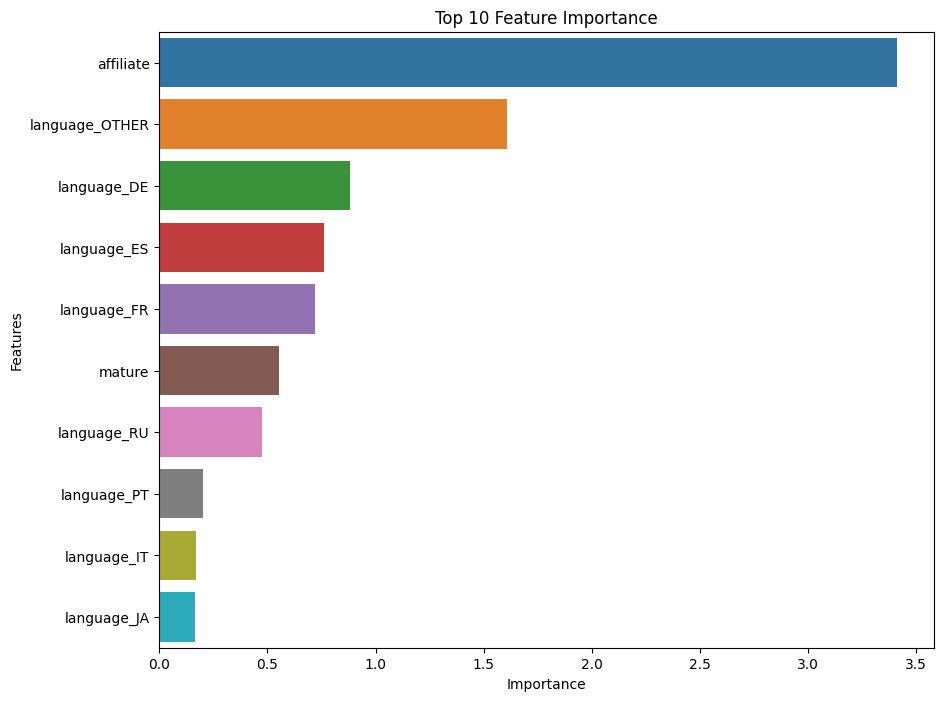

In [11]:
# Get the absolute values of the coefficients
feature_importance = np.abs(baseline_model.coef_[0])

# Map features to their importance
features = X_train.columns
importance_dict = dict(zip(features, feature_importance))

# Sort features by importance
sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)
sorted_importance_df = pd.DataFrame(sorted_importance, columns=['Feature', 'Importance'])

plt.figure(figsize=(10, 8))
sns.barplot(x="Importance", y="Feature", data=sorted_importance_df[:10])

plt.title('Top 10 Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

In [16]:
# Statistical importance

# Add a constant to the predictor variable set to represent the intercept
X_train_with_const = sm.add_constant(X_train)

# Fit the logistic regression model
model = sm.Logit(y_train, X_train_with_const).fit()

# Display the summary of the model to see the coefficient estimates along with their statistical significance
print(model.summary())

/Users/yuqizhang/venv/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Optimization terminated successfully.
         Current function value: 0.104172
         Iterations 16
                           Logit Regression Results                           
Dep. Variable:           dead_account   No. Observations:               134491
Model:                          Logit   Df Residuals:                   134466
Method:                           MLE   Df Model:                           24
Date:                Wed, 27 Mar 2024   Pseudo R-squ.:                  0.2403
Time:                        22:45:08   Log-Likelihood:                -14010.
converged:                       True   LL-Null:                       -18441.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.1733   1.21e+06  -1.79e-06      1.000   -2.38e+06    2.38e+06
views          -

/Users/yuqizhang/venv/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


- The `views` coefficient is very small and negative, indicating a negligible decrease in the log odds of the outcome with an increase in views, and it's **statistically significant** (p-value of 0.0).
- The `mature` variable has a negative coefficient of -0.4480, suggesting that being mature is associated with a decrease in the log odds of the outcome, and it is **statistically significant**.
- The `life_time` coefficient of -0.0003 indicates a small negative effect on the log odds of the outcome with an increase in life time, which is **statistically significant**.
- The `affiliate` variable has a large negative coefficient of -4.0195, suggesting a substantial decrease in the log odds of the outcome for affiliates, with a very strong **statistical significance**.